In [21]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10, num_negative_samples=1,
                 sparse=True).to(device)
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.01)

In [23]:
dataset.num_classes

7

Epoch: 01, Loss: 8.0749, Acc: 0.1520
Epoch: 02, Loss: 6.0442, Acc: 0.1830
Epoch: 03, Loss: 4.9483, Acc: 0.2170
Epoch: 04, Loss: 4.1257, Acc: 0.2610
Epoch: 05, Loss: 3.4681, Acc: 0.3020
Epoch: 06, Loss: 2.9481, Acc: 0.3320
Epoch: 07, Loss: 2.5328, Acc: 0.3640
Epoch: 08, Loss: 2.2083, Acc: 0.3960
Epoch: 09, Loss: 1.9428, Acc: 0.4320
Epoch: 10, Loss: 1.7251, Acc: 0.4520
Epoch: 11, Loss: 1.5557, Acc: 0.4690
Epoch: 12, Loss: 1.4193, Acc: 0.4960
Epoch: 13, Loss: 1.3098, Acc: 0.5190
Epoch: 14, Loss: 1.2246, Acc: 0.5400
Epoch: 15, Loss: 1.1548, Acc: 0.5550
Epoch: 16, Loss: 1.0988, Acc: 0.5710
Epoch: 17, Loss: 1.0563, Acc: 0.5880
Epoch: 18, Loss: 1.0192, Acc: 0.6060
Epoch: 19, Loss: 0.9921, Acc: 0.6200
[ 19.50383     15.348822    -0.03022114   9.934413    11.834958
   2.4091072   16.525574     8.402598    14.283419    20.427534
  14.288901    14.689713   -14.606634    19.657063    20.706467
   7.255418    -5.5406413   17.184069    11.336093    18.680193
  19.535069     7.3301077    9.314471    

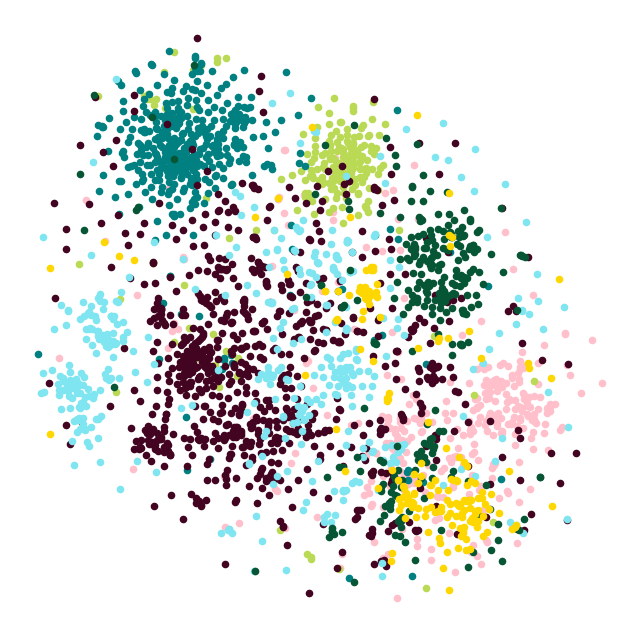

In [24]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask], max_iter=150)
    return acc


for epoch in range(1, 20):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')


@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        print(z[y == i, 0], z[y == i, 1])
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()


colors = ['#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700']
plot_points(colors)

In [4]:
model.eval()
z = model(torch.arange(data.num_nodes, device=device))

In [2]:
data.to_dict()

{'x': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'edge_index': tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
         [ 633, 1862, 2582,  ...,  598, 1473, 2706]]),
 'y': tensor([3, 4, 4,  ..., 3, 3, 3]),
 'train_mask': tensor([ True,  True,  True,  ..., False, False, False]),
 'val_mask': tensor([False, False, False,  ..., False, False, False]),
 'test_mask': tensor([False, False, False,  ...,  True,  True,  True])}

In [8]:
sum(data.val_mask)

tensor(500)

In [9]:
sum(data.train_mask)

tensor(140)

In [10]:
sum(data.test_mask)

tensor(1000)

In [16]:
data.to_dict()

{'x': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'edge_index': tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
         [ 633, 1862, 2582,  ...,  598, 1473, 2706]]),
 'y': tensor([3, 4, 4,  ..., 3, 3, 3]),
 'train_mask': tensor([ True,  True,  True,  ..., False, False, False]),
 'val_mask': tensor([False, False, False,  ..., False, False, False]),
 'test_mask': tensor([False, False, False,  ...,  True,  True,  True])}

In [22]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [22]:
data.num_edges

10556

In [16]:
z = model()
model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask], max_iter=150)

0.595

In [21]:
z[data.test_mask].shape

torch.Size([1000, 128])